# Stochastic volatility
This Notebook demos how to construct a stochastic volatility model and fit it to data. We'll use the Verhulst model for the volatility process, s.t.
\begin{cases}
Y_t = \mu + V_t W_t, \\
dV_t = \kappa V_t (\gamma - V_t)dt + \sigma V_t dU_t, \\
\end{cases}
where $\mu, \beta, \gamma \in \mathbb{R}$, and $\kappa, \sigma \in \mathbb{R}_+$.$\{U_t\}$ is a Brownian motion, wheras $\{W_t\}$ is assumed to follow a [skew logistic distribution](https://docs.pyro.ai/en/stable/distributions.html#skewlogistic). 

We begin with importing the necessary libraries for defining the model.

In [1]:
from pyfilter import __version__
from pyfilter.timeseries import StateSpaceModel, models as m, AffineObservations

print(__version__)

0.22.2


Next, we define the governing dynamics, and set the default tensor to be CUDA

In [2]:
import torch


def go(vol, level):
    return level


def fo(vol, level):
    return vol.values

Next, we shall define our model. In order to do so, we must specify priors for the different parameters. Given their support, we assume that
\begin{cases}
    \kappa \sim \mathcal{E}(10), \\
    \mu \sim \mathcal{N}(0, 1), \\
    \gamma \sim \mathcal{LN}(0, 1), \\    
    \sigma \sim \mathcal{LN}(-2, 0.5), \\
    \alpha \sim \mathcal{LN}(0, 0.1).
\end{cases}
Next, we define the model in code and get (utilizing $\Delta t = 0.2$ and 5 integration steps)

In [3]:
from torch.distributions import Exponential, Normal, Exponential, LogNormal
from pyfilter.distributions import DistributionWrapper, Prior
from pyro.distributions import SkewLogistic

priors = (
    Prior(Exponential, rate=10.0), 
    Prior(LogNormal, loc=0.0, scale=1.0), 
    Prior(LogNormal, loc=-2.0, scale=0.5)
)
logvol = m.Verhulst(*priors, dt=0.2, num_steps=5)

asymmetry_prior = Prior(LogNormal, loc=0.0, scale=0.1)
dist = DistributionWrapper(SkewLogistic, loc=0.0, scale=1.0, asymmetry=asymmetry_prior)

obs = AffineObservations((go, fo), (Prior(Normal, loc=0.0, scale=1.0),), dist)

stockmodel = StateSpaceModel(logvol, obs)

And that defines the model. Next, we need a dataset to train on, we'll use AAPL

In [4]:
import numpy as np
import pandas as pd
from yfinance import Ticker

tick = Ticker("AAPL")
hist = tick.history(period="max")

y = np.log(hist["Close"]).diff().loc["2005-01-01":] * 100.0

We plot the data to get an idea of its volatility

<AxesSubplot:xlabel='Date'>

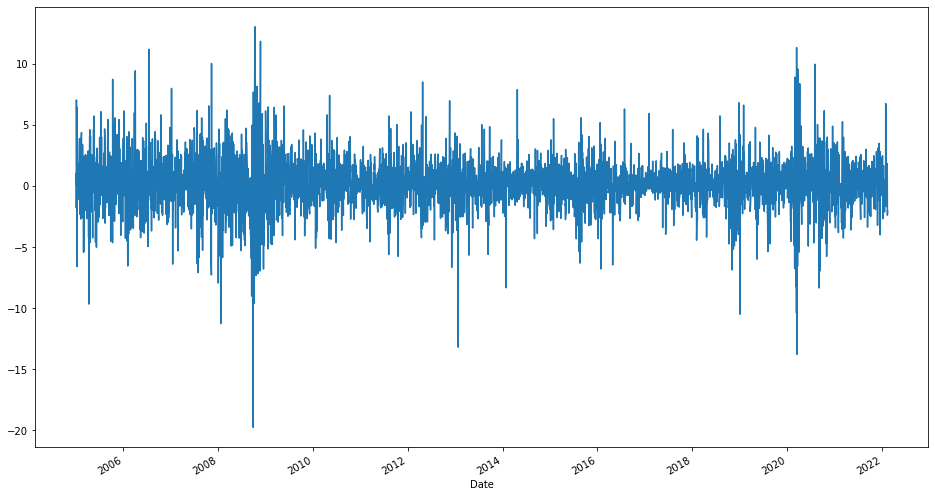

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 9))
y.plot(ax=ax)

In order to fit the model to the given data, we need an algorithm. We shall use the NESSMC2, which is a hybrid between the SMC$^2$ algorithm by Chopin et al., and the NESS algorithm by Crisan and Miguez. Furthermore, since we are using particle filters, we need to decide on which proposal to use - should we go with the Bootstrap or something more advanced? For this example, we will use the APF as the problem's so low dimensional. Importing the relevant classes and fitting the data yields

In [6]:
from pyfilter.inference.sequential import NESSMC2
from pyfilter.filters import APF

predictions = 5
train = y.iloc[:-predictions]

train_tensor = torch.from_numpy(train.values).float()
 
algs = list()
for i in range(2):
    filt = APF(stockmodel.copy(), 500)
    alg = NESSMC2(filt, 2_000, switch=2_000, smc2_kw={"n_steps": 3, "threshold": 0.2}).cuda()
    
    state = alg.fit(train_tensor)
    
    algs.append((state, alg))

NESSMC2: 100%|█████████████████████████████████████████████████████████████████████| 4304/4304 [04:04<00:00, 17.64it/s]


Next, we plot the posterior distributions. The first corresponds to the standard deviation of the latent process. The last three ones correspond to the mean, exposure to variance and dof of the Student's t distribution.

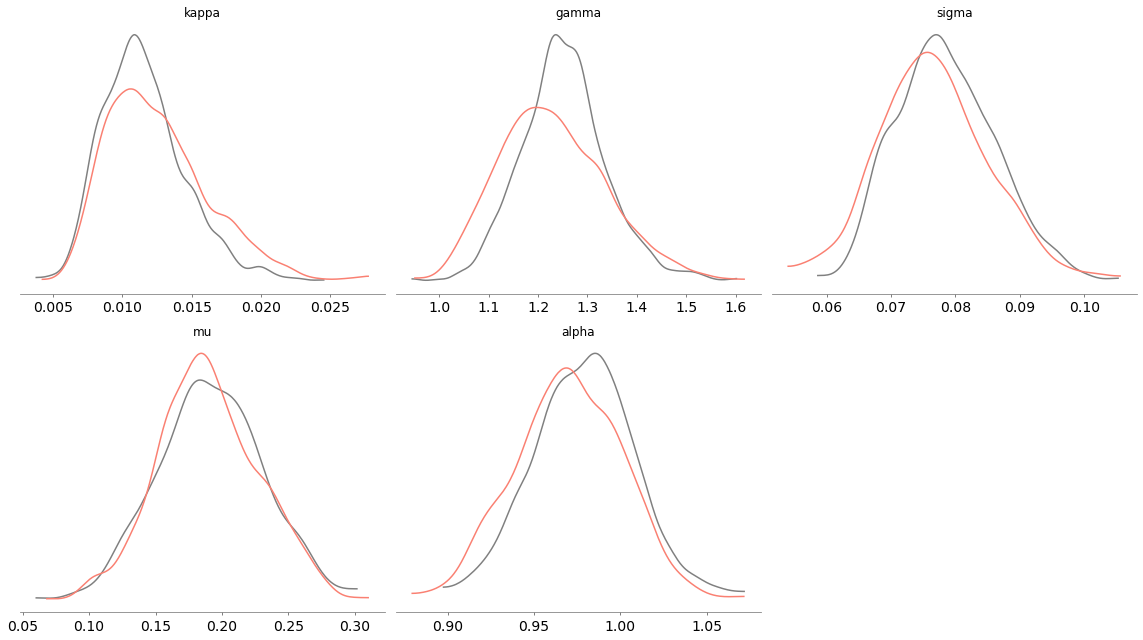

In [7]:
from arviz import plot_posterior

colors = ["gray", "salmon"]

ax = None
for iteration, (_, alg) in enumerate(algs):
    params = alg.filter.ssm.concat_parameters(constrained=True).cpu()
    ax = plot_posterior(params.unsqueeze(0).numpy(), figsize=(16, 9), ax=ax, hdi_prob="hide", point_estimate=None, color=colors[iteration])
    
name_mapping = ["kappa", "gamma", "sigma", "mu", "alpha"]
for ax_, name in zip(ax.flatten(), name_mapping):
    ax_.set_title(name)
    
plt.tight_layout()

Let's plot a crude estimate of the underlying volatility. I say crude here because we uniformly weight the trajectories.

<AxesSubplot:xlabel='Date'>

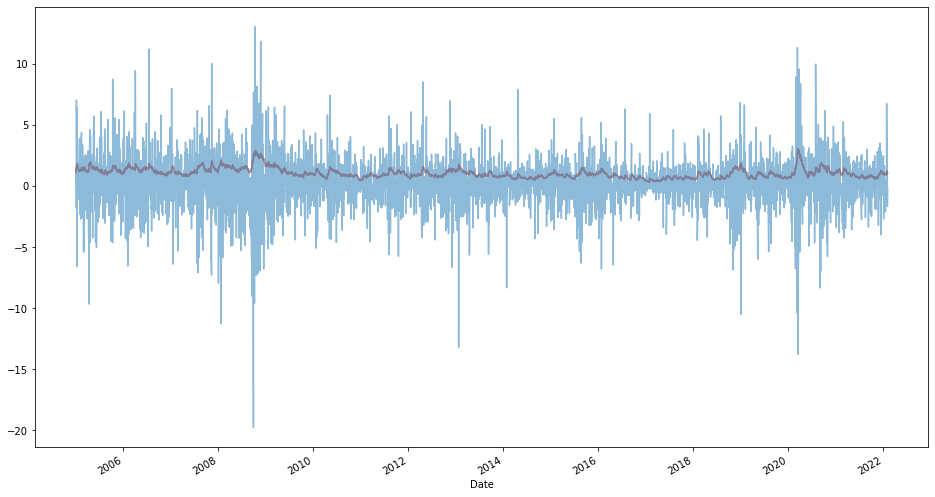

In [8]:
fig, ax = plt.subplots(figsize=(16, 9))

for iteration, (_, alg) in enumerate(algs):
    means = state.filter_state.filter_means[1:].mean(1).cpu().numpy()
    ax.plot(train.index, means, color=colors[iteration], alpha=0.8)

train.plot(ax=ax, alpha=0.5)

We can clearly see the volatility spike caused by the COVID breakout.

A plot over the ESS.

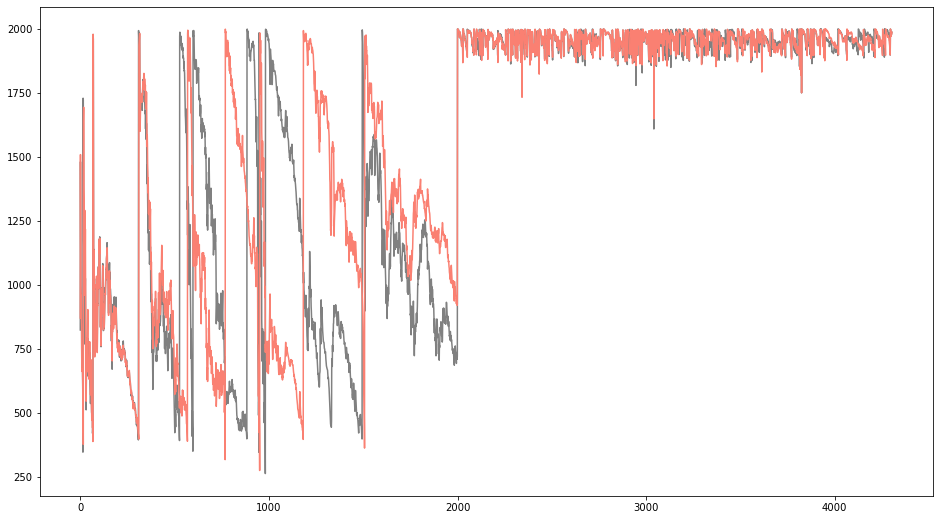

In [9]:
fig, ax = plt.subplots(figsize=(16, 9))
for i, (state, _) in enumerate(algs):
    ax.plot(state.ess.values().cpu().numpy(), color=colors[i])

Let's, finally, get an estimate of the return distribution 5 steps (days) into the future.

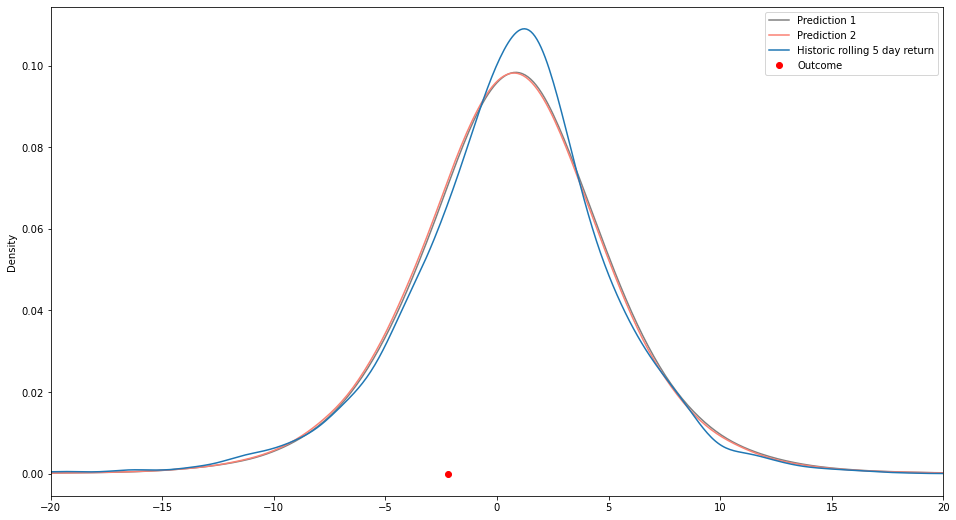

In [10]:
fig, ax = plt.subplots(figsize=(16, 9))

for i, (state, alg) in enumerate(algs):    
    _, yt = alg.predict(predictions, state, aggregate=False)  
    
    mask = yt.abs() > 100.0
    yt[mask] = 100.0 * yt[mask].sign()
    
    final = pd.Series(yt.sum(0).view(-1).cpu().numpy()).sort_values()[::50]    

    final.plot.kde(ax=ax, label=f"Prediction {i + 1:d}", color=colors[i])

train.rolling(predictions).sum().rename(f"Historic rolling {predictions:d} day return").plot.kde(ax=ax)

ax.set_xlim(-20, 20)
ax.plot(y.iloc[-predictions:].sum(), 0, "ro", label="Outcome")

ax.legend()